In [1]:
# -*- coding: utf-8 -*-
"""
【機械学習】モデル評価・指標についてのまとめと実行( w/Titanicデータセット)
https://qiita.com/kenmatsu4/items/0a862a42ceb178ba7155
Created on Wed Jun 27 15:31:14 2018

@author: Akitaka
"""

# 地味だけど重要ないぶし銀「モデル評価・指標」に関連して、
# Cross Validation、ハイパーパラメーターの決定、ROC曲線、AUC等についてまとめと、
# Pythonでの実行デモについて書きました。

# 本記事はQiita Machine Learning Advent Calendar 2015 7日目のものです。
# http://qiita.com/advent-calendar/2015/machinelearning
# ふと見てみたら12/7が空いていたので、急遽書いてみました :grin:
# コードの全文はこちらのGitHubリポジトリにあります。
# https://github.com/matsuken92/Qiita_Contents/blob/master/Model_evaluation/Model_evaluation.ipynb
# 
# データセット "Titanic"
# おなじみ、Titanicデータセットを使用します。
# 客船Titanicの生存者に関するデータで、分類のデモ用データとしてよく用いられています。

# まずは前処理とデータインポート
# seabornにデータセットがあるので、それを使います。

# %matplotlib inline
import numpy as np
import pandas as pd
from time import time
from operator import itemgetter

import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

from sklearn import cross_validation
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, precision_recall_curve, auc, roc_curve

titanic = sns.load_dataset("titanic")

headers = [c for c in titanic.columns]
headers.insert(0,"ID")
print(tabulate(titanic[0:5], headers, tablefmt="pipe"))

print(titanic.head())

# カテゴリ変数をダミー変数化
def convert_dummies(df, key):
    dum = pd.get_dummies(df[key])
    ks = dum.keys()
    print("Removing {} from {}...".format(ks[0], key))
    dum.columns = [key + "_" + str(k) for k in ks]  
    df = pd.concat((df, dum.iloc[:,1:]), axis=1)
    df = df.drop(key, axis=1)
    return df

titanic = convert_dummies(titanic, "who")
titanic = convert_dummies(titanic, "class")
titanic = convert_dummies(titanic, "sex")
titanic = convert_dummies(titanic, "alone")
titanic = convert_dummies(titanic, "embark_town")
titanic = convert_dummies(titanic, "deck")
titanic = convert_dummies(titanic, "embarked")

titanic['age'] = titanic.age.fillna(titanic.age.median())
titanic['adult_male'] = titanic.adult_male.map( {True: 1, False: 0} ).astype(int)
titanic['alone'] = titanic.adult_male.map( {True: 1, False: 0} ).astype(int)

# 使用しない変数をドロップ
titanic = titanic.drop("alive", axis=1)
titanic = titanic.drop("pclass", axis=1)

# 再確認
print(titanic.head())


C:\Users\Akitaka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Akitaka\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


|   ID |   survived |   pclass | sex    |   age |   sibsp |   parch |    fare | embarked   | class   | who   | adult_male   | deck   | embark_town   | alive   | alone   |
|-----:|-----------:|---------:|:-------|------:|--------:|--------:|--------:|:-----------|:--------|:------|:-------------|:-------|:--------------|:--------|:--------|
|    0 |          0 |        3 | male   |    22 |       1 |       0 |  7.25   | S          | Third   | man   | True         | nan    | Southampton   | no      | False   |
|    1 |          1 |        1 | female |    38 |       1 |       0 | 71.2833 | C          | First   | woman | False        | C      | Cherbourg     | yes     | False   |
|    2 |          1 |        3 | female |    26 |       0 |       0 |  7.925  | S          | Third   | woman | False        | nan    | Southampton   | yes     | True    |
|    3 |          1 |        1 | female |    35 |       1 |       0 | 53.1    | S          | First   | woman | False        | C      | Southampto

In [3]:
#%%
# 1. データセットの分割
# 1-1. ホールドアウト法
# ある割合で今持っている教師ありデータを、「訓練データ」と「テストデータ」に分割し学習と評価を行う。
# 例えば 訓練データ：テストデータ の比率が 80:20 の場合、こんな感じです。

# 訓練データ(80%), テストデータ(20%)に分割する
target = titanic.iloc[:, 0]
data = titanic.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,14]]
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data, target, test_size=0.2, random_state=None)

print([d.shape for d in [X_train, X_test, y_train, y_test]])

# * 訓練データを多くすると学習の精度は上がるがモデルの評価の精度が下がる。
# * テストデータを多くするとモデル評価の精度は上がるが学習の精度が下がる、
# というトレードオフに注意して割合を決める。


# SVM(線形カーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
print(u"再代入誤り率：", 1 - clf.score(X_train, y_train))
print(u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test))

# SVM(rbfカーネル)で分類し、誤り率を算出
clf = svm.SVC(kernel='rbf', C=1).fit(X_train, y_train)
print(u"再代入誤り率：", 1 - clf.score(X_train, y_train))
print(u"ホールドアウト誤り率：", 1 - clf.score(X_test, y_test))



[(712, 13), (179, 13), (712,), (179,)]
再代入誤り率： 0.1783707865168539
ホールドアウト誤り率： 0.15642458100558654
再代入誤り率： 0.1109550561797753
ホールドアウト誤り率： 0.24022346368715086


In [4]:
# %%
# 1-2. クロスバリデーション(Cross Validation, CV): Stratified k-fold
# K-fold
# まず、シンプルなK-foldについてです。データが30個ある場合を考えます。
# n_foldsが分割数で、今持っているデータセットをその分割数で分割し、
# 下記のようにどれをテストデータとするか、全組み合わせを添え字リストの形で出力します。

# KFold
# n_foldsで指定した数値でデータを分割。n_folds=5とした場合、5分割
# してそのうちの１つをテストデータとし、5通りパターンを生成する。
kf = KFold(30, n_folds=5,shuffle=False)
for tr, ts in kf:
    print("{0} {1}".format(tr, ts))
    
# Stratified k-fold
# 上のK-foldから、手元のデータセットにおける各クラス比率をキープするように、
# データセットの分割を行う手法。
# 次節で使用するcross_validation.cross_val_scoreはこれを採用している。
    # StratifiedKFold
# 各クラスごとの抽出率を元データの比率に合わせたKFoldの改良版

label = np.r_[np.repeat(0,20), np.repeat(1,10)]
skf = StratifiedKFold(label, n_folds=5, shuffle=False)
for tr, ts in skf:
    print("{0} {1}".format(tr, ts))
    
# 実行してみる
# SVM(線形カーネル)で分類し、誤り率を算出
# 5分割のStratifiedKFoldでそれぞれスコアを算出

clf = svm.SVC(kernel='rbf', C=1)
scores = cross_validation.cross_val_score(clf, data, target, cv=5,)
print("scores: ", scores)
print("Accuracy: {0:.2f} (+/- {1:.2f})".format(scores.mean(), scores.std() * 2))


[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [0 1 2 3 4 5]
[ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 18 19 20 21 22 23 24 25 26 27 28 29] [12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 24 25 26 27 28 29] [18 19 20 21 22 23]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] [24 25 26 27 28 29]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 22 23 24 25 26 27 28 29] [ 0  1  2  3 20 21]
[ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27 28 29] [ 4  5  6  7 22 23]
[ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19 20 21 22 23 26 27 28 29] [ 8  9 10 11 24 25]
[ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19 20 21 22 23 24 25 28 29] [12 13 14 15 26 27]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 26 27] [16 17 18 19 28 29]
scores:  [0.65363128 0.72067039 0.73033708 0.73033708 0.78531073]


In [5]:
#%%
# 2. より良いハイパーパラメーターの探し方
# 2-1. Exhaustive Grid Search
# つまり、片っぱしから設定したハイパーパラメーターを全部試してどれが一番良いかを探す方法です。
# 時間はかかりますが、指定したものは全部試すので、良いものが見つかる可能性が高いです。
# まず、パラメーターの取りうる値を下記のように設定します。
param_grid = [
  {'kernel': ['rbf','linear'], 'C': np.linspace(0.1,2.0,20),}
 ]
# test用
param_grid = [
  {'kernel': ['rbf'], 'C': np.linspace(0.1,2.0,10),}
 ]

# それをgrid_search.GridSearchCVにSVC(Support Vector Classifier)と共に
# 渡してあげて実行する。

# 実行
svc = svm.SVC(random_state=None)
clf = grid_search.GridSearchCV(svc, param_grid)
res = clf.fit(X_train, y_train)

# 結果の表示
print("score: ", clf.score(X_test, y_test))
print("best_params:", res.best_params_)
print("best_estimator:", res.best_estimator_)

# 指定したパラメーターを全て試して一番良い結果のスコア、どのパラメーターが良かったか、
# 詳細な指定パラメータ、を表示しています。

# ただこれ、やっぱり時間がかかりました。
# さらに試したいパラメーターが増えた時に全部見ていられなくなってしまいます。
# なので次にパラメータの選び方にランダムさを取り入れた手法をピックアップします。


score:  0.7597765363128491
best_params: {'C': 1.3666666666666667, 'kernel': 'rbf'}
best_estimator: SVC(C=1.3666666666666667, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [8]:
#%%
# 2-2. Randomized Parameter Optimization
# 試したいパラメーターを増やしてみます。今度はパラメータの多い、Randomforestを使います。

param_dist = {'n_estimators': range(4,20,2), 'min_samples_split': range(1,30,2), 'criterion':['gini','entropy']}

# 実行して、処理時間がどのくらいかを表示してみます。
# （※ パラメータの組み合わせ数が20以下の場合、「GridSearchを使え」とエラーが出ます）

n_iter_search = 20
rfc = RandomForestClassifier(max_depth=None, min_samples_split=1, random_state=None)
random_search = grid_search.RandomizedSearchCV(rfc, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)
start = time()
random_search.fit(X_train, y_train)
end   = time()
print("パラメーター数: {0}, 経過時間: {1:0.3f}秒".format(n_iter_search, end - start))

# トップ3のパラメータセッティングは下記で表示します。

# トップ3パラメータ
top_scores = sorted(random_search.grid_scores_, key=itemgetter(1), reverse=True)[:3]
for i, score in enumerate(top_scores):
    print("Model with rank: {0}".format(i + 1))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          score.mean_validation_score,
          np.std(score.cv_validation_scores)))
    print("Parameters: {0}".format(score.parameters))
    print("")


パラメーター数: 20, 経過時間: 1.904秒
Model with rank: 1
Mean validation score: 0.834 (std: 0.023)
Parameters: {'n_estimators': 14, 'min_samples_split': 5, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.829 (std: 0.016)
Parameters: {'n_estimators': 8, 'min_samples_split': 11, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.827 (std: 0.021)
Parameters: {'n_estimators': 16, 'min_samples_split': 15, 'criterion': 'entropy'}



In [9]:
#%%
# 3.評価指標
# ある病気の診断結果を例に考えます。
# その時、診断結果と真の値で下記のように４つの取りうる結果があります。
# テーブルにすると下記の通りです。
# 
# 基本、
# * T(true), F(false)
# * P(positive), N(negative)
# の組み合わせで、検診の場合
# trueは「診断結果と真の値が一致している」、falseは「診断結果と真の値が異なっている」
# positiveは「病気である」、negativeは「病気でない」
# を表します。
#
# これを元に下記の評価指標を算出します。
# 正答率 [Accuracy]
# Accuracy = (TP+TN)/(TP+FP+FN+TN)
# 
# 適合率(精度) [Precision]
# 診断結果が病気(Positive)あるものの中での正答率。
# Precision = (TP)/(TP+FP)
#
# 再現率 [Recall]
# 真の値が病気であるものの中での正答率
# Recall = (TP)/(TP+FN)
#
# F値 (F-measure)
# 適合率と再現率の調和平均。
# F-measure = (2*Precision*Recall)/(Precision+Recall)
#
# 3-1. 算出してみる
# SVM(線形カーネル)で分類し、評価指標を算出
clf = svm.SVC(kernel='linear', C=1, probability=True).fit(X_train, y_train)
print(u"Accuracy:", clf.score(X_test, y_test))   
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["not Survived", "Survived"]))


Accuracy: 0.8435754189944135
              precision    recall  f1-score   support

not Survived       0.87      0.89      0.88       114
    Survived       0.79      0.77      0.78        65

 avg / total       0.84      0.84      0.84       179



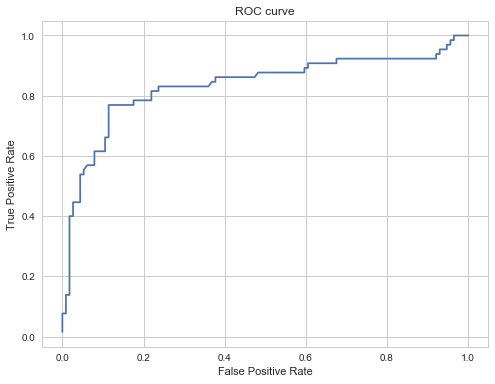

Area Under Curve: 0.785


In [10]:
#%%
# 3-2.ROCとAUC
# AUCという指標の解説をします。
# これはROC(Receiver Operating Characteristic；受信者動作特性)曲線から
# 導出できるものですが、以前の記事、
# 【統計学】ROC曲線とは何か、アニメーションで理解する。
# http://qiita.com/kenmatsu4/items/550b38f4fa31e9af6f4f
# で詳しく解説していますのでこちらをご参照ください。
#
# このROC曲線の下の面積がAUC(Area Under the Curve)です。（そのまんまですね…）

prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds= roc_curve(y_test, prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# タイタニックデータをSVM(線形カーネル)で分類した時のROC曲線が下記の通りです。

# AUCの算出
precision, recall, thresholds = precision_recall_curve(y_test, prob)
area = auc(recall, precision)
print("Area Under Curve: {0:.3f}".format(area))

# 参考
# WEB
# 　Scikit Learn User Guide 3. Model selection and evaluation
# 　　　http://scikit-learn.org/stable/model_selection.html
#
# 書籍
# 「はじめてのパターン認識」平井 有三
# 「言語処理のための機械学習入門」奥村学